# VTNet Leave-One-User-Out Evaluation on Non-Contaminated Dataset



In [1]:
import os
from pathlib import Path
from functools import lru_cache

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support,
)



In [ ]:
# GPU configuration and diagnostics
print(f"TensorFlow version: {tf.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("\n=== GPU Diagnostics ===")
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")
try:
    print(f"CUDA available: {tf.test.is_gpu_available(cuda_only=True)}")
except:
    print("CUDA availability check failed (method may be deprecated)")

print(f"\nPhysical devices: {tf.config.list_physical_devices()}")
print(f"GPU devices: {tf.config.list_physical_devices('GPU')}")

# Check for CUDA/cuDNN libraries
if tf.config.list_physical_devices('GPU'):
    print("\n✅ GPU detected! TensorFlow can use your GPU.")
    # Configure GPU memory growth to avoid allocating all memory
    try:
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("✅ GPU memory growth enabled")
    except RuntimeError as e:
        print(f"Warning: Could not configure GPU memory growth: {e}")
else:
    print("\n❌ No GPU detected by TensorFlow.")
    print("\nPossible solutions:")
    print("1. Install/update CUDA toolkit (TensorFlow 2.18.1 requires CUDA 12.x)")
    print("2. Install cuDNN library compatible with your CUDA version")
    print("3. Make sure CUDA/bin and cuDNN are in your PATH")
    print("4. Restart your Jupyter kernel after installing CUDA/cuDNN")
    print("5. Try: pip install tensorflow[and-cuda] (includes CUDA dependencies)")
    print("\nYour system shows CUDA 12.9 via nvidia-smi, but TensorFlow may need:")
    print("- CUDA toolkit installed (not just drivers)")
    print("- cuDNN library in PATH")
    print("- Compatible TensorFlow build")



TensorFlow version: 2.10.1
Num GPUs Available:  1

=== GPU Diagnostics ===
Built with CUDA: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [6]:
# Paths and configuration (resolve relative to this notebook)
def find_project_root(start: Path, marker: str = "non-contaminated datasets", max_levels: int = 6) -> Path:
    current = start.resolve()
    for _ in range(max_levels):
        if (current / marker).exists():
            return current
        current = current.parent
    raise FileNotFoundError(f"Could not locate project root containing '{marker}' starting from {start}")

current_dir = Path.cwd()
try:
    base_dir = find_project_root(current_dir)
except FileNotFoundError as e:
    print(e)
    base_dir = current_dir  # fallback to current directory

scanpaths_dir = base_dir / "non-contaminated datasets" / "Scanpaths"
raw_csv_dir = base_dir / "non-contaminated datasets" / "Organized Normalized Raw Eye Tracking Data"
target_csv_path = base_dir / "Code" / "Utilities" / "users_literacy_results.csv"

print(f"Working directory: {current_dir}")
print(f"Project root: {base_dir}")
print(f"Scanpaths dir exists: {scanpaths_dir.exists()}")
print(f"Raw CSV dir exists: {raw_csv_dir.exists()}")
print(f"Target CSV path: {target_csv_path}")

# Data constants
IMG_HEIGHT = 150
IMG_WIDTH = 150
SEQ_LENGTH = 150
BATCH_SIZE = 16
EPOCHS = 12
VALIDATION_SPLIT = 0.1
RANDOM_SEED = 42

skip_users = {5, 20}
graph_types = ["bar", "line", "pie"]
class_map = {"illiterate": 0, "literate": 1}
label_names = ["illiterate", "literate"]

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)



Working directory: c:\Users\tonyg\OneDrive\Desktop\University Files\Eye Tracking Research\LOUO CV
Project root: C:\Users\tonyg\OneDrive\Desktop\University Files\Eye Tracking Research
Scanpaths dir exists: True
Raw CSV dir exists: True
Target CSV path: C:\Users\tonyg\OneDrive\Desktop\University Files\Eye Tracking Research\Code\Utilities\users_literacy_results.csv


In [7]:
# Load literacy labels for reference
literacy_df = pd.read_csv(target_csv_path)
literacy_df["MEDIA_ID"] = literacy_df["MEDIA_ID"].astype(int)
literacy_df["LITERACY"] = literacy_df["LITERACY"].astype(int)
literacy_map = dict(zip(literacy_df["MEDIA_ID"], literacy_df["LITERACY"]))



In [8]:
def parse_user_id(path: Path) -> int:
    """Extract user ID from a path segment like user_12."""
    name = path.name
    if name.startswith("user_"):
        try:
            return int(name.split("_")[1])
        except (IndexError, ValueError):
            return None
    return None


def parse_question_id(filename: str) -> int:
    """Extract question number from filenames like user_1_question_23_scanpath.png."""
    try:
        part = filename.split("question_")[1]
        return int(part.split("_")[0].split(".")[0])
    except (IndexError, ValueError):
        return None



In [9]:
def load_timeseries_from_csv(csv_path: Path, max_length: int = SEQ_LENGTH) -> np.ndarray:
    """Load and preprocess gaze coordinates and normalized pupil delta data from CSV."""
    try:
        df = pd.read_csv(csv_path)
        # Extract 7 columns: FPOGX, FPOGY, LPS, RPS, delta_LPMM, delta_RPMM, delta_BPMM
        data = df[["FPOGX", "FPOGY", "LPS", "RPS", "delta_LPMM", "delta_RPMM", "delta_BPMM"]].values.astype(np.float32)
        data = data[~np.isnan(data).any(axis=1)]
    except Exception:
        data = np.zeros((0, 7), dtype=np.float32)

    if data.shape[0] >= max_length:
        data = data[-max_length:]
    else:
        pad_len = max_length - data.shape[0]
        padding = np.zeros((pad_len, 7), dtype=np.float32)
        data = np.vstack([padding, data])
    return data.astype(np.float32)



In [10]:
def collect_samples_for_graph(graph_type: str):
    """Collect all scanpath/csv pairs for a given graph type."""
    samples = []
    graph_scan_dir = scanpaths_dir / graph_type
    graph_csv_dir = raw_csv_dir / graph_type

    for literacy_name, label in class_map.items():
        scan_class_dir = graph_scan_dir / literacy_name
        csv_class_dir = graph_csv_dir / literacy_name
        if not scan_class_dir.exists():
            continue

        for user_dir in sorted(scan_class_dir.glob("user_*")):
            user_id = parse_user_id(user_dir)
            if user_id is None or user_id in skip_users:
                continue

            csv_user_dir = csv_class_dir / f"user_{user_id}"
            if not csv_user_dir.exists():
                continue

            for img_path in sorted(user_dir.glob("*.png")):
                question_id = parse_question_id(img_path.name)
                csv_name = img_path.stem.replace("_scanpath", "") + ".csv"
                csv_path = csv_user_dir / csv_name
                if not csv_path.exists():
                    continue

                samples.append(
                    {
                        "image": img_path,
                        "csv": csv_path,
                        "label": label,
                        "user_id": user_id,
                        "question_id": question_id,
                    }
                )
    return samples



In [11]:
def _py_load_timeseries(path_tensor):
    if hasattr(path_tensor, "numpy"):
        path_bytes = path_tensor.numpy()
    else:
        path_bytes = path_tensor
    if isinstance(path_bytes, bytes):
        path_str = path_bytes.decode("utf-8")
    else:
        path_str = str(path_bytes)
    return load_timeseries_from_csv(Path(path_str))


def make_dataset(samples, shuffle=False, batch_size=BATCH_SIZE):
    if len(samples) == 0:
        raise ValueError("No samples provided to build dataset.")

    image_paths = [str(s["image"]) for s in samples]
    csv_paths = [str(s["csv"]) for s in samples]
    labels = [s["label"] for s in samples]

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, csv_paths, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(samples), reshuffle_each_iteration=True)

    def load_sample(image_path, csv_path, label):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        image = tf.image.rgb_to_grayscale(image)
        image = tf.cast(image, tf.float32) / 255.0

        timeseries = tf.py_function(func=_py_load_timeseries, inp=[csv_path], Tout=tf.float32)
        timeseries.set_shape((SEQ_LENGTH, 7))

        label_onehot = tf.one_hot(label, depth=2)
        return (image, timeseries), label_onehot

    dataset = dataset.map(load_sample, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset



In [12]:
def create_vtnet_model(rnn_type="gru", hidden_size=256):
    scanpath_input = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1), name="scanpath_input")
    timeseries_input = tf.keras.layers.Input(shape=(SEQ_LENGTH, 7), name="timeseries_input")

    # CNN branch
    x = tf.keras.layers.Conv2D(6, (5, 5), activation="relu", name="conv1")(scanpath_input)
    x = tf.keras.layers.MaxPooling2D((2, 2), name="pool1")(x)
    x = tf.keras.layers.Conv2D(16, (5, 5), activation="relu", name="conv2")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), name="pool2")(x)
    x = tf.keras.layers.Flatten(name="cnn_flatten")(x)
    cnn_features = tf.keras.layers.Dense(50, activation="relu", name="cnn_fc1")(x)

    # RNN branch
    if rnn_type.lower() == "gru":
        rnn_layer = tf.keras.layers.GRU(hidden_size, name="rnn_gru")
    elif rnn_type.lower() == "lstm":
        rnn_layer = tf.keras.layers.LSTM(hidden_size, name="rnn_lstm")
    else:
        rnn_layer = tf.keras.layers.SimpleRNN(hidden_size, name="rnn_simple")

    rnn_features = rnn_layer(timeseries_input)

    fused = tf.keras.layers.Concatenate(name="fusion_concat")([cnn_features, rnn_features])
    fused = tf.keras.layers.Dense(20, activation="relu", name="fusion_fc1")(fused)
    output = tf.keras.layers.Dense(2, activation="softmax", name="output")(fused)

    model = tf.keras.models.Model(inputs=[scanpath_input, timeseries_input], outputs=output, name="VTNet_LOUO")
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model



In [9]:
def run_fold(train_samples, test_samples, epochs=EPOCHS):
    # Split train into train/val
    test_size = max(1, int(len(train_samples) * VALIDATION_SPLIT))
    labels = [s["label"] for s in train_samples]
    n_classes = len(set(labels))
    
    # Only use stratification if test_size is large enough
    # Stratification requires test_size >= n_classes
    use_stratify = test_size >= n_classes
    
    train_paths, val_paths = train_test_split(
        train_samples,
        test_size=test_size,
        random_state=RANDOM_SEED,
        stratify=labels if use_stratify else None,
    )

    train_ds = make_dataset(train_paths, shuffle=True, batch_size=BATCH_SIZE)
    val_ds = make_dataset(val_paths, shuffle=False, batch_size=BATCH_SIZE)
    test_ds = make_dataset(test_samples, shuffle=False, batch_size=BATCH_SIZE)

    model = create_vtnet_model()

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stop],
        verbose=0,
    )

    # Evaluate on test user
    y_true = []
    y_pred = []

    for (images, timeseries), labels in test_ds:
        preds = model.predict([images, timeseries], verbose=0)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
    }
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average="binary",
        zero_division=0,
    )
    metrics.update({"precision": precision, "recall": recall, "f1": f1})
    metrics["confusion_matrix"] = confusion_matrix(y_true, y_pred, labels=[0, 1])

    return metrics, history.history, y_true, y_pred



In [10]:
def run_louo_for_graph(graph_type: str):
    samples = collect_samples_for_graph(graph_type)
    if len(samples) == 0:
        raise ValueError(f"No samples found for graph type {graph_type}")

    df = pd.DataFrame(samples)
    user_ids = sorted(df["user_id"].unique())

    overall_true = []
    overall_pred = []
    fold_results = {}

    for user_id in user_ids:
        train_samples = df[df["user_id"] != user_id].to_dict("records")
        test_samples = df[df["user_id"] == user_id].to_dict("records")

        if len(test_samples) == 0 or len(train_samples) == 0:
            continue

        metrics, history, y_true, y_pred = run_fold(train_samples, test_samples)

        fold_results[user_id] = {
            "metrics": metrics,
            "history": history,
        }

        overall_true.extend(y_true)
        overall_pred.extend(y_pred)

    precision, recall, f1, _ = precision_recall_fscore_support(
        overall_true,
        overall_pred,
        average="binary",
        zero_division=0,
    )

    aggregate = {
        "accuracy": accuracy_score(overall_true, overall_pred),
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": confusion_matrix(overall_true, overall_pred, labels=[0, 1]),
        "folds": fold_results,
    }

    return aggregate



In [11]:
results = {}

for graph in graph_types:
    print(f"\n=== Running VTNet LOUO for {graph} graphs ===")
    results[graph] = run_louo_for_graph(graph)
    agg = results[graph]
    print(
        f"Accuracy: {agg['accuracy']:.3f} | Precision: {agg['precision']:.3f} | "
        f"Recall: {agg['recall']:.3f} | F1: {agg['f1']:.3f}"
    )




=== Running VTNet LOUO for bar graphs ===
Accuracy: 0.547 | Precision: 0.481 | Recall: 0.509 | F1: 0.494

=== Running VTNet LOUO for line graphs ===
Accuracy: 0.548 | Precision: 0.480 | Recall: 0.414 | F1: 0.444

=== Running VTNet LOUO for pie graphs ===
Accuracy: 0.312 | Precision: 0.300 | Recall: 0.429 | F1: 0.353


In [12]:
summary_df = pd.DataFrame(
    [
        {
            "graph_type": graph,
            "accuracy": res["accuracy"],
            "precision": res["precision"],
            "recall": res["recall"],
            "f1": res["f1"],
        }
        for graph, res in results.items()
    ]
).sort_values("graph_type")
summary_df



,graph_type,accuracy,precision,recall,f1
0,bar,0.546599,0.480874,0.508671,0.494382
1,line,0.547739,0.480000,0.413793,0.444444
2,pie,0.312500,0.300000,0.428571,0.352941


In [13]:
graph_type = "bar"

fold_rows = []
for user_id, info in results.get(graph_type, {}).get("folds", {}).items():
    m = info["metrics"]
    fold_rows.append(
        {
            "user_id": user_id,
            "accuracy": m["accuracy"],
            "precision": m["precision"],
            "recall": m["recall"],
            "f1": m["f1"],
        }
    )

pd.DataFrame(fold_rows).sort_values("user_id")



,user_id,accuracy,precision,recall,f1
0,1,0.000000,0.0,0.000000,0.000000
1,2,0.933333,0.0,0.000000,0.000000
2,3,0.615385,0.0,0.000000,0.000000
3,4,0.857143,1.0,0.857143,0.923077
4,6,0.727273,0.0,0.000000,0.000000
5,7,0.076923,0.0,0.000000,0.000000
6,8,0.666667,1.0,0.666667,0.800000
7,9,0.181818,1.0,0.181818,0.307692
8,10,0.937500,1.0,0.937500,0.967742
9,11,0.500000,0.0,0.000000,0.000000


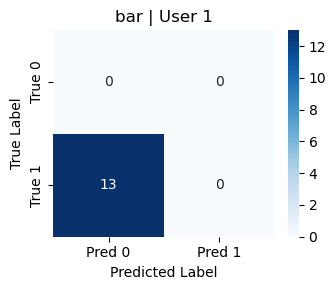

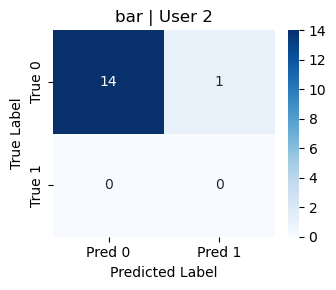

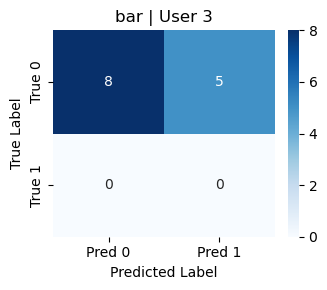

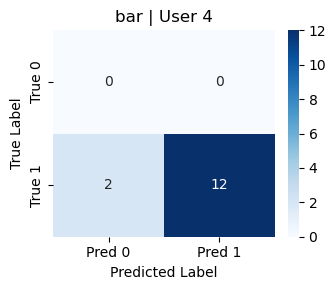

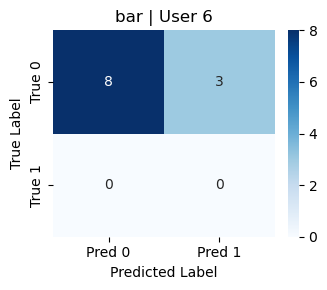

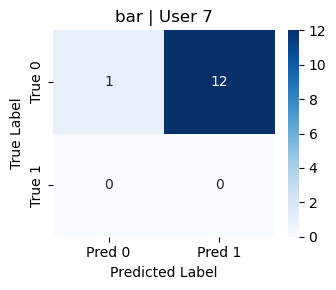

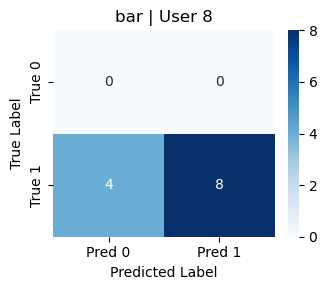

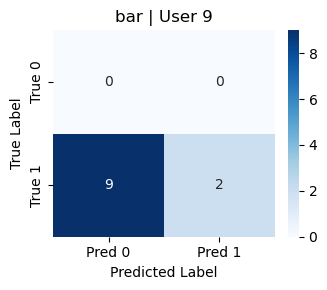

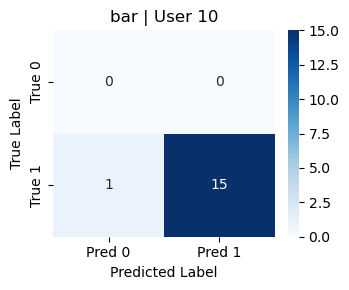

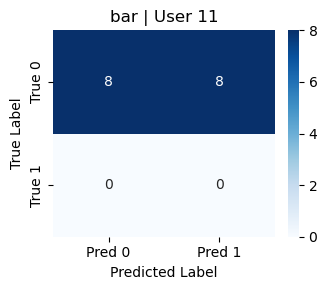

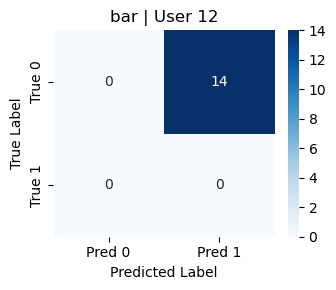

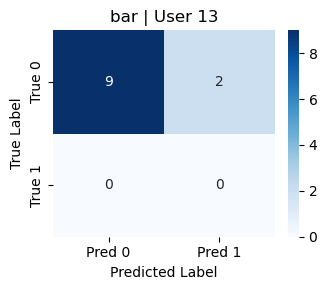

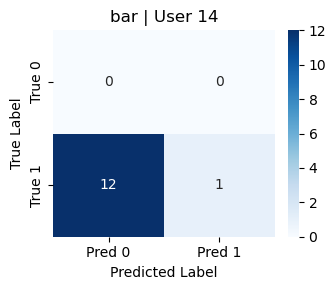

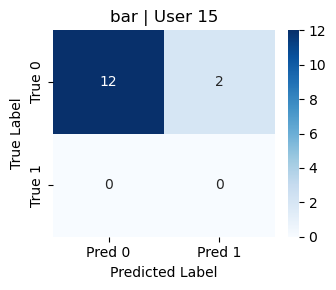

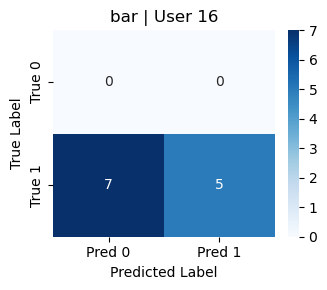

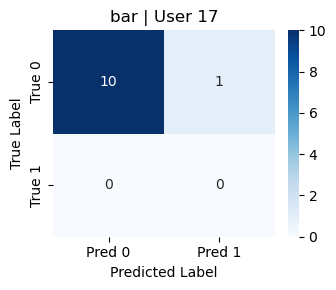

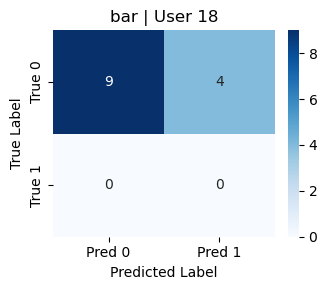

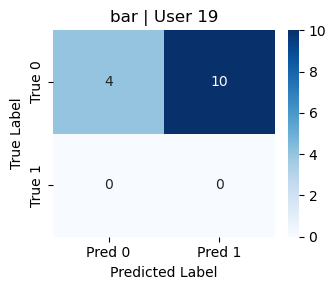

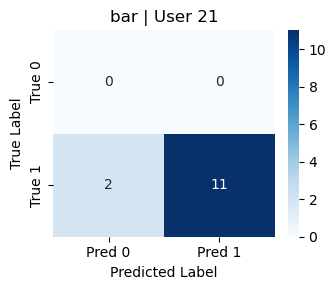

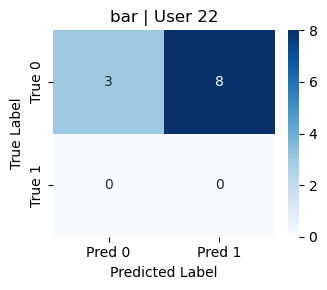

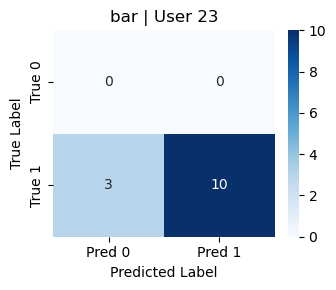

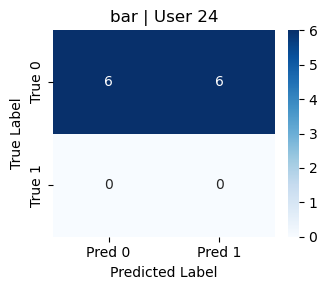

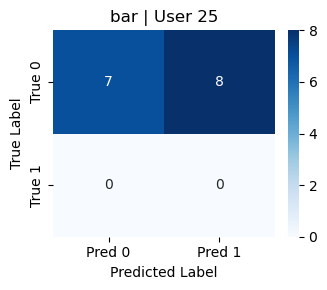

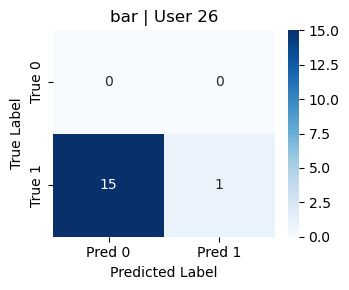

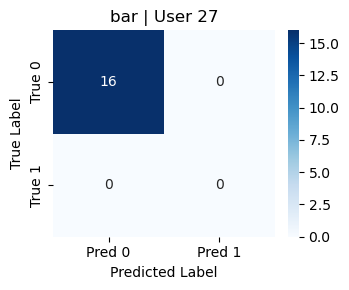

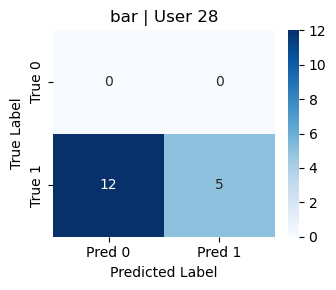

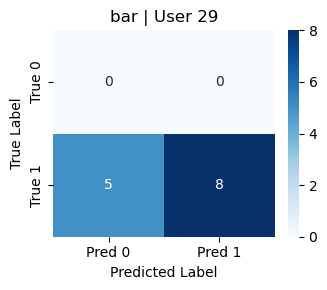

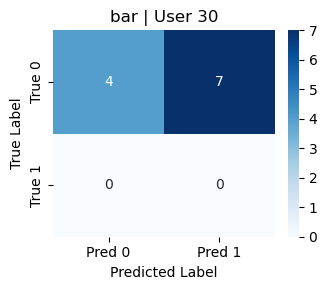

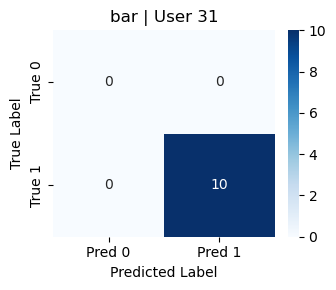

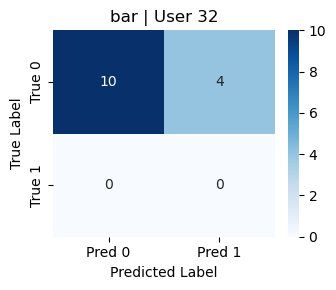

In [14]:
graph_type = "bar"

if graph_type in results:
    for user_id, info in results[graph_type]["folds"].items():
        cm = info["metrics"]["confusion_matrix"]
        plt.figure(figsize=(3.5, 3))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"],
        )
        plt.title(f"{graph_type} | User {user_id}")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.tight_layout()
        plt.show()
else:
    print(f"Graph type '{graph_type}' not in results.")



In [15]:
# Calculate new accuracy based on user-level binary classification
# For each user: if accuracy > 0.5, count as correct; if <= 0.5, count as wrong
# Then calculate accuracy as (correct users) / (total users) for each graph type

user_level_accuracy = {}

for graph_type in graph_types:
    if graph_type not in results:
        continue
    
    correct_users = 0
    total_users = 0
    user_details = []
    
    for user_id, info in results[graph_type]["folds"].items():
        user_acc = info["metrics"]["accuracy"]
        total_users += 1
        
        if user_acc > 0.5:
            correct_users += 1
            user_details.append({
                "user_id": user_id,
                "accuracy": user_acc,
                "correct": True
            })
        else:
            user_details.append({
                "user_id": user_id,
                "accuracy": user_acc,
                "correct": False
            })
    
    new_accuracy = correct_users / total_users if total_users > 0 else 0.0
    user_level_accuracy[graph_type] = {
        "new_accuracy": new_accuracy,
        "correct_users": correct_users,
        "total_users": total_users,
        "user_details": user_details
    }
    
    print(f"{graph_type} graphs:")
    print(f"  New Accuracy: {new_accuracy:.3f} ({correct_users}/{total_users} users)")
    print()

# Create summary DataFrame
summary_user_level = pd.DataFrame([
    {
        "graph_type": graph,
        "new_accuracy": info["new_accuracy"],
        "correct_users": info["correct_users"],
        "total_users": info["total_users"]
    }
    for graph, info in user_level_accuracy.items()
]).sort_values("graph_type")

print("Summary:")
summary_user_level


bar graphs:
  New Accuracy: 0.533 (16/30 users)

line graphs:
  New Accuracy: 0.500 (15/30 users)

pie graphs:
  New Accuracy: 0.267 (4/15 users)

Summary:


,graph_type,new_accuracy,correct_users,total_users
0,bar,0.533333,16,30
1,line,0.500000,15,30
2,pie,0.266667,4,15


# Feature Correlation Analysis

Analyzing feature correlations with the target variable for the 7 time-series features used by VTNet.


In [2]:
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')


In [13]:
# Analyze the CSV file structure
sample_csv = raw_csv_dir / "bar" / "illiterate" / "user_2" / "user_2_question_1.csv"
if sample_csv.exists():
    sample_df = pd.read_csv(sample_csv)
    print("="*80)
    print("CSV FILE STRUCTURE ANALYSIS")
    print("="*80)
    print(f"\nShape: {sample_df.shape} (rows × columns)")
    print(f"\nVTNet uses 7 columns from this CSV:")
    vtnet_cols = ["FPOGX", "FPOGY", "LPS", "RPS", "delta_LPMM", "delta_RPMM", "delta_BPMM"]
    for col in vtnet_cols:
        if col in sample_df.columns:
            print(f"  • {col}: {sample_df[col].dtype}")
            print(f"    Range: [{sample_df[col].min():.4f}, {sample_df[col].max():.4f}]")
            print(f"    Mean: {sample_df[col].mean():.4f}, Std: {sample_df[col].std():.4f}")
            print(f"    Missing: {sample_df[col].isna().sum()} / {len(sample_df)}")
    print(f"\nAll columns in CSV ({len(sample_df.columns)}):")
    print(list(sample_df.columns))
else:
    print(f"Sample CSV not found at {sample_csv}")


CSV FILE STRUCTURE ANALYSIS

Shape: (70, 62) (rows × columns)

VTNet uses 7 columns from this CSV:
  • FPOGX: float64
    Range: [0.2455, 0.8580]
    Mean: 0.5049, Std: 0.1646
    Missing: 0 / 70
  • FPOGY: float64
    Range: [0.0870, 0.8061]
    Mean: 0.5643, Std: 0.1668
    Missing: 0 / 70
  • LPS: float64
    Range: [0.8457, 0.9439]
    Mean: 0.8810, Std: 0.0192
    Missing: 0 / 70
  • RPS: float64
    Range: [0.8495, 0.9377]
    Mean: 0.8818, Std: 0.0191
    Missing: 0 / 70
  • delta_LPMM: float64
    Range: [-0.9896, 0.9980]
    Mean: 0.1655, Std: 0.3643
    Missing: 0 / 70
  • delta_RPMM: float64
    Range: [-0.8444, 0.9877]
    Mean: 0.3078, Std: 0.3770
    Missing: 0 / 70
  • delta_BPMM: float64
    Range: [-0.8983, 0.8491]
    Mean: 0.2366, Std: 0.3385
    Missing: 0 / 70

All columns in CSV (62):
['MEDIA_ID', 'MEDIA_NAME', 'CNT', 'TIME(2024/03/12 12:23:43.601)', 'TIMETICK(f=10000000)', 'FPOGX', 'FPOGY', 'FPOGS', 'FPOGD', 'FPOGID', 'FPOGV', 'BPOGX', 'BPOGY', 'BPOGV', 'CX', 'CY

In [14]:
def extract_aggregated_features_from_timeseries(csv_path: Path):
    """
    Extract aggregated statistics from the 7 time-series columns.
    Returns a dictionary with feature names and values.
    """
    try:
        df = pd.read_csv(csv_path)
        vtnet_cols = ["FPOGX", "FPOGY", "LPS", "RPS", "delta_LPMM", "delta_RPMM", "delta_BPMM"]
        
        # Filter to only valid rows (no NaN)
        df_clean = df[vtnet_cols].dropna()
        
        if len(df_clean) == 0:
            return None
        
        features = {}
        for col in vtnet_cols:
            if col in df_clean.columns:
                col_data = df_clean[col].values
                # Extract multiple statistics for each column
                features[f"{col}_mean"] = np.mean(col_data)
                features[f"{col}_std"] = np.std(col_data)
                features[f"{col}_median"] = np.median(col_data)
                features[f"{col}_min"] = np.min(col_data)
                features[f"{col}_max"] = np.max(col_data)
                features[f"{col}_range"] = np.max(col_data) - np.min(col_data)
        
        # Additional derived features
        if "FPOGX" in df_clean.columns and "FPOGY" in df_clean.columns:
            # Gaze movement distance
            x_diff = np.diff(df_clean["FPOGX"].values)
            y_diff = np.diff(df_clean["FPOGY"].values)
            distances = np.sqrt(x_diff**2 + y_diff**2)
            features["gaze_movement_mean"] = np.mean(distances)
            features["gaze_movement_std"] = np.std(distances)
            features["gaze_movement_total"] = np.sum(distances)
        
        return features
    except Exception as e:
        return None

def load_aggregated_features_for_graph(graph_type: str):
    """
    Load aggregated features from all CSV files for a given graph type.
    Returns feature matrix X, labels y, and user groups.
    """
    records = []
    labels = []
    groups = []
    
    graph_csv_dir = raw_csv_dir / graph_type
    
    for literacy_name, label in class_map.items():
        csv_class_dir = graph_csv_dir / literacy_name
        if not csv_class_dir.exists():
            continue
        
        for user_dir in sorted(csv_class_dir.glob("user_*")):
            user_id = parse_user_id(user_dir)
            if user_id is None or user_id in skip_users:
                continue
            
            for csv_file in sorted(user_dir.glob("*.csv")):
                features = extract_aggregated_features_from_timeseries(csv_file)
                if features is None:
                    continue
                
                records.append(features)
                labels.append(label)
                groups.append(user_id)
    
    if not records:
        return pd.DataFrame(), pd.Series(dtype=int), np.array([])
    
    # Create DataFrame
    all_columns = set()
    for record in records:
        all_columns.update(record.keys())
    
    all_columns = sorted(all_columns)
    X = pd.DataFrame([{col: record.get(col, np.nan) for col in all_columns} for record in records])
    y = pd.Series(labels, name="literacy")
    groups = np.array(groups)
    
    return X, y, groups


In [15]:
def analyze_feature_correlations(X, y):
    """
    Analyze feature correlations with target using pandas and sklearn.
    Returns DataFrame with correlations, mutual information, and F-statistics.
    """
    # Ensure X and y are aligned by index
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    # Impute missing values for analysis
    X_imputed = pd.DataFrame(
        SimpleImputer(strategy='median').fit_transform(X),
        columns=X.columns,
        index=X.index
    )
    
    # 1. Calculate Pearson correlation with target
    correlations = X_imputed.corrwith(y)
    
    # 2. Calculate F-statistics and p-values
    f_scores, p_values = f_classif(X_imputed, y)
    
    # 3. Calculate mutual information
    mi_scores = mutual_info_classif(X_imputed, y, random_state=42)
    
    # Combine into DataFrame
    correlation_df = pd.DataFrame({
        'feature': X.columns,
        'correlation': correlations.values,
        'abs_correlation': np.abs(correlations.values),
        'f_score': f_scores,
        'p_value': p_values,
        'mutual_info': mi_scores
    }).sort_values('abs_correlation', ascending=False, na_position='last')
    
    return correlation_df


In [16]:
# Perform feature correlation analysis for each graph type
feature_analysis_results = {}

for graph in graph_types:
    print(f"\n{'='*60}")
    print(f"Feature Analysis for {graph.upper()} graphs")
    print(f"{'='*60}\n")
    
    X, y, groups = load_aggregated_features_for_graph(graph)
    
    if len(X) == 0:
        print("  No data found. Skipping.\n")
        continue
    
    print(f"  Samples: {len(X)} | Features: {X.shape[1]} | Users: {len(np.unique(groups))}")
    
    # Correlation analysis
    correlation_df = analyze_feature_correlations(X, y)
    
    feature_analysis_results[graph] = {
        'correlation_df': correlation_df,
        'X': X,
        'y': y,
        'groups': groups
    }
    
    print(f"\nTop 15 features by correlation with target:")
    print(correlation_df.head(15)[['feature', 'correlation', 'p_value', 'f_score', 'mutual_info']].to_string(index=False))
    print()



Feature Analysis for BAR graphs

  Samples: 780 | Features: 45 | Users: 30

Top 15 features by correlation with target:
           feature  correlation      p_value   f_score  mutual_info
    delta_LPMM_std    -0.324034 1.587195e-20 91.271826     0.107910
           RPS_min     0.301773 6.921299e-18 77.948430     0.253342
           LPS_min     0.301613 7.216978e-18 77.857522     0.209592
    delta_LPMM_min     0.285391 4.387073e-16 68.985184     0.068769
    delta_BPMM_std    -0.284521 5.426984e-16 68.528587     0.092164
          RPS_mean     0.256527 3.464420e-13 54.803440     0.125381
          LPS_mean     0.255936 3.938526e-13 54.533650     0.102124
        LPS_median     0.254657 5.193135e-13 53.952357     0.222997
        RPS_median     0.253261 7.010563e-13 53.322140     0.215093
    delta_RPMM_std    -0.250276 1.324010e-12 51.988794     0.069119
  delta_LPMM_range    -0.206202 6.164006e-09 34.548982     0.075346
    delta_BPMM_min     0.202462 1.166460e-08 33.253876     0.03

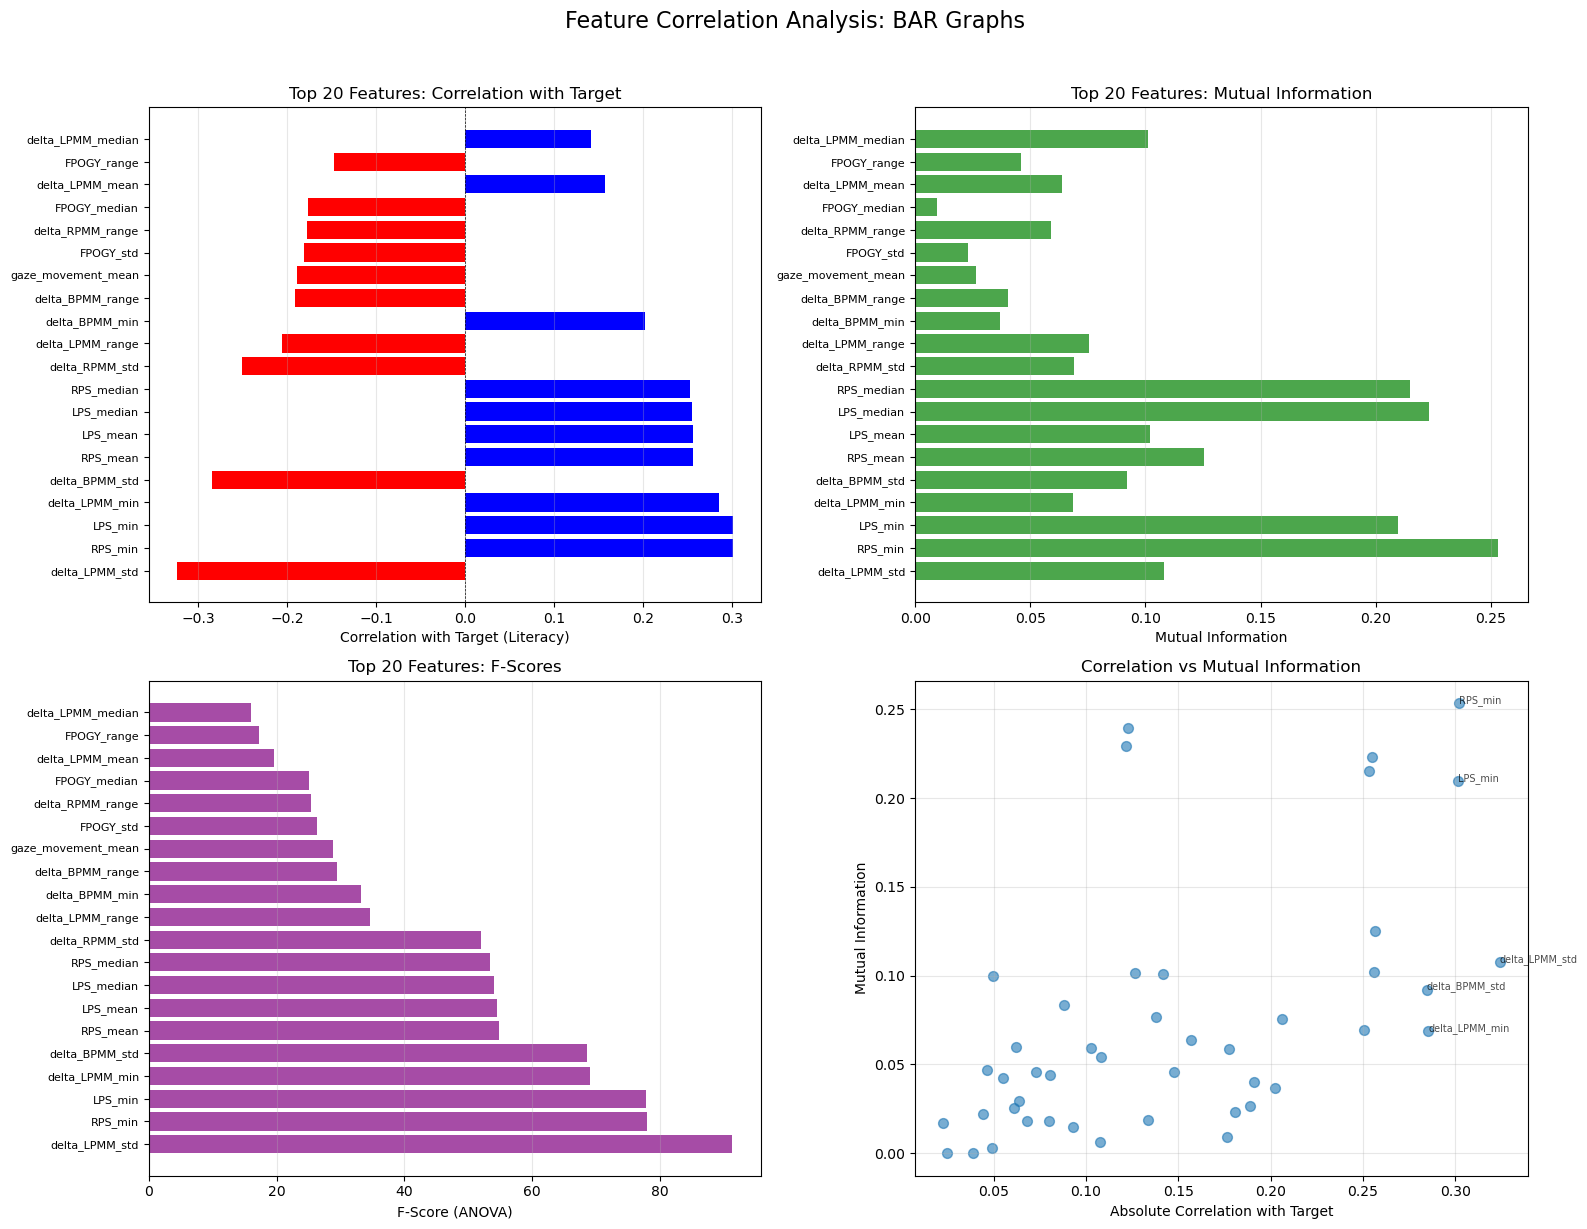

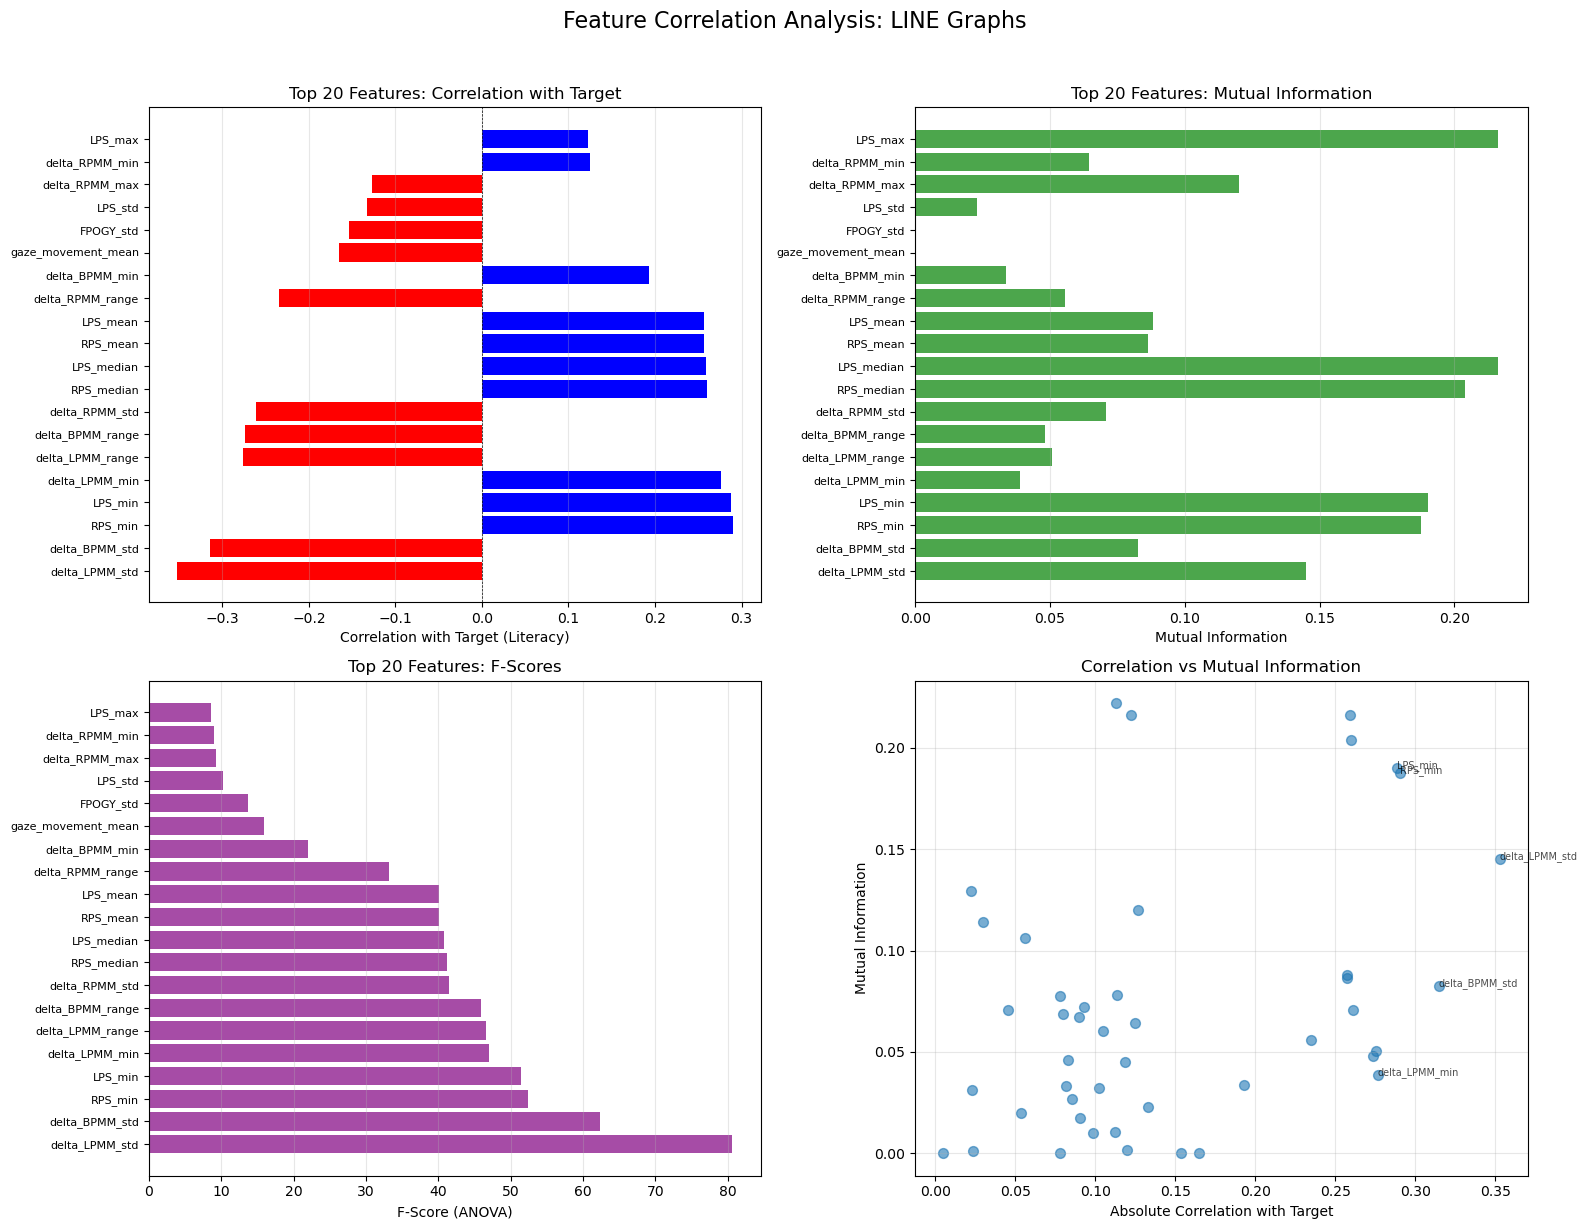

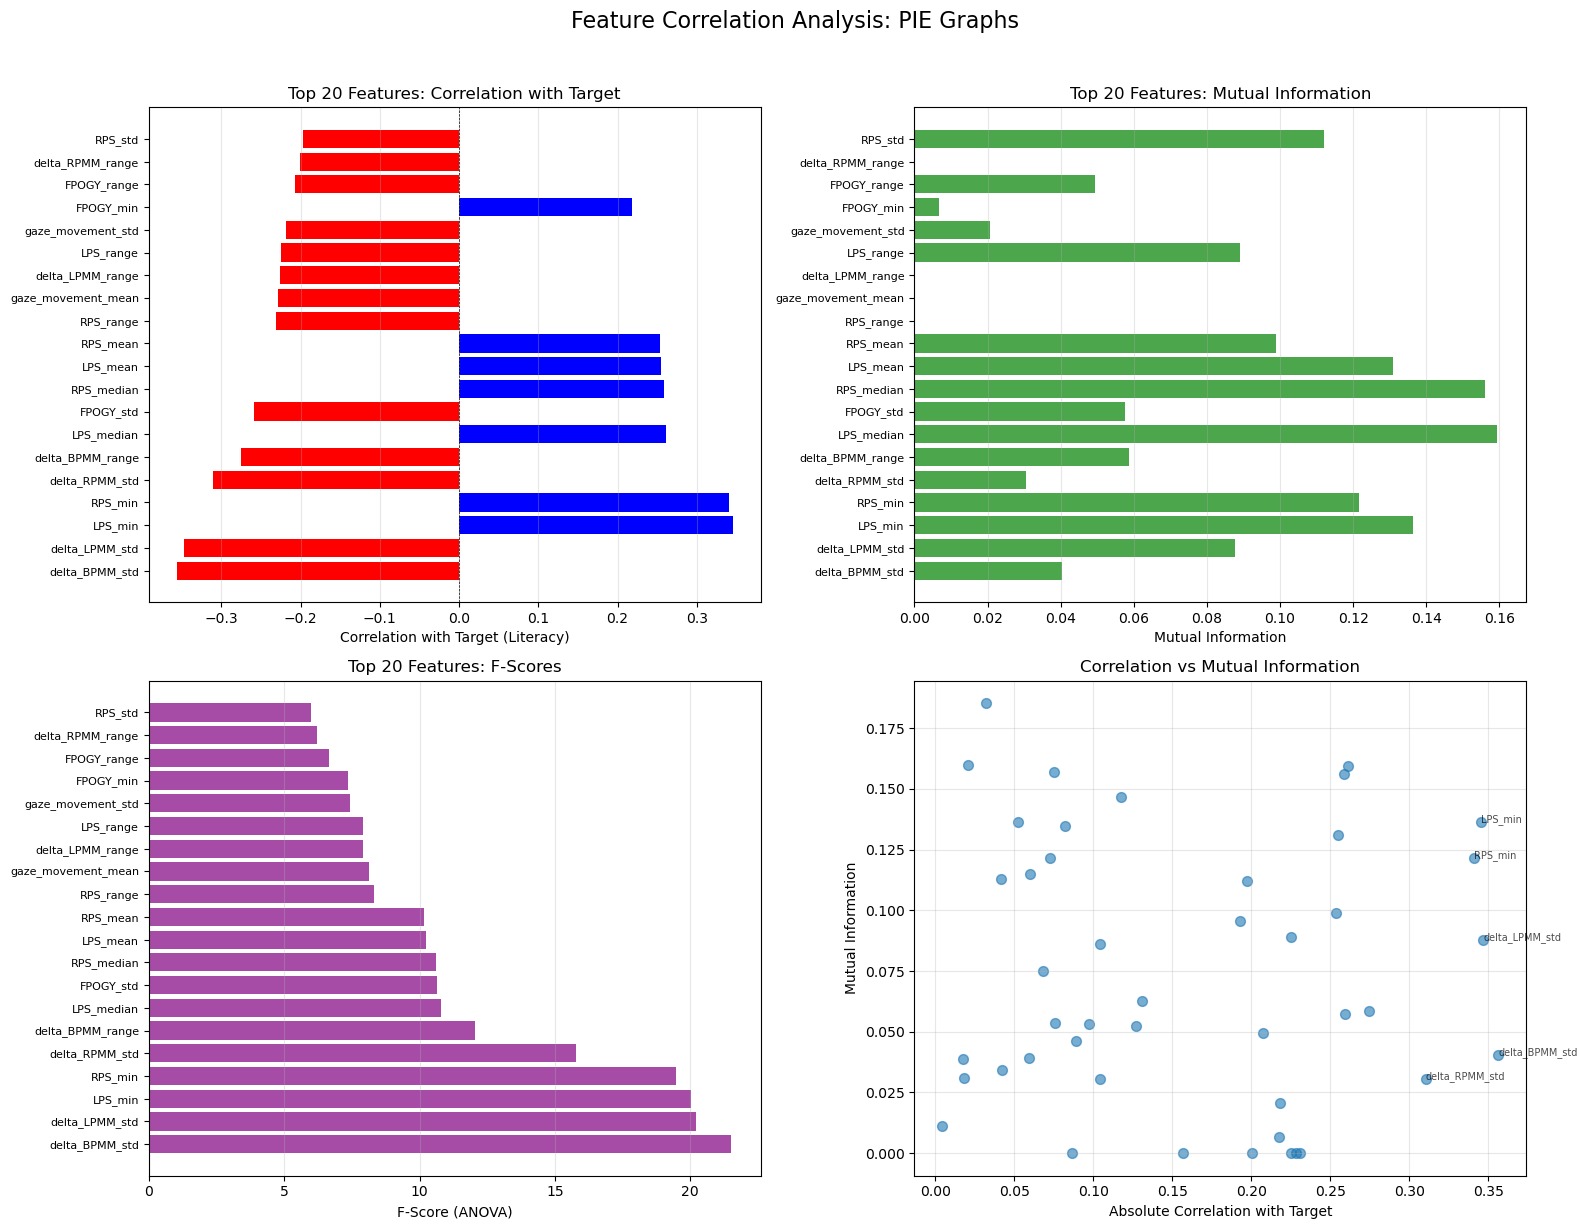

In [17]:
# Visualize feature correlations for each graph type
for graph in graph_types:
    if graph not in feature_analysis_results:
        continue
    
    correlation_df = feature_analysis_results[graph]['correlation_df']
    
    # Filter out NaN correlations
    correlation_df_clean = correlation_df.dropna(subset=['correlation'])
    
    if len(correlation_df_clean) == 0:
        continue
    
    # Plot top correlations
    top_n = min(20, len(correlation_df_clean))
    top_features = correlation_df_clean.head(top_n)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Feature Correlation Analysis: {graph.upper()} Graphs', fontsize=16, y=1.02)
    
    # Plot 1: Correlation with target
    ax1 = axes[0, 0]
    colors = ['red' if x < 0 else 'blue' for x in top_features['correlation']]
    ax1.barh(range(len(top_features)), top_features['correlation'], color=colors)
    ax1.set_yticks(range(len(top_features)))
    ax1.set_yticklabels(top_features['feature'], fontsize=8)
    ax1.set_xlabel('Correlation with Target (Literacy)')
    ax1.set_title(f'Top {top_n} Features: Correlation with Target')
    ax1.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
    ax1.grid(axis='x', alpha=0.3)
    
    # Plot 2: Mutual Information
    ax2 = axes[0, 1]
    ax2.barh(range(len(top_features)), top_features['mutual_info'], color='green', alpha=0.7)
    ax2.set_yticks(range(len(top_features)))
    ax2.set_yticklabels(top_features['feature'], fontsize=8)
    ax2.set_xlabel('Mutual Information')
    ax2.set_title(f'Top {top_n} Features: Mutual Information')
    ax2.grid(axis='x', alpha=0.3)
    
    # Plot 3: F-scores
    ax3 = axes[1, 0]
    ax3.barh(range(len(top_features)), top_features['f_score'], color='purple', alpha=0.7)
    ax3.set_yticks(range(len(top_features)))
    ax3.set_yticklabels(top_features['feature'], fontsize=8)
    ax3.set_xlabel('F-Score (ANOVA)')
    ax3.set_title(f'Top {top_n} Features: F-Scores')
    ax3.grid(axis='x', alpha=0.3)
    
    # Plot 4: Correlation vs Mutual Information scatter
    ax4 = axes[1, 1]
    valid_mask = ~(pd.isna(correlation_df_clean['correlation']) | pd.isna(correlation_df_clean['mutual_info']))
    if valid_mask.sum() > 0:
        scatter_data = correlation_df_clean[valid_mask]
        ax4.scatter(scatter_data['abs_correlation'], scatter_data['mutual_info'], alpha=0.6, s=50)
        ax4.set_xlabel('Absolute Correlation with Target')
        ax4.set_ylabel('Mutual Information')
        ax4.set_title('Correlation vs Mutual Information')
        ax4.grid(alpha=0.3)
        
        # Annotate top features
        top_5 = scatter_data.nlargest(5, 'abs_correlation')
        for idx, row in top_5.iterrows():
            ax4.annotate(row['feature'][:25], 
                        (row['abs_correlation'], row['mutual_info']),
                        fontsize=7, alpha=0.7)
    
    plt.tight_layout()
    plt.show()


In [18]:
# Summary statistics of feature correlations
summary_correlation_stats = []

for graph in graph_types:
    if graph not in feature_analysis_results:
        continue
    
    corr_df = feature_analysis_results[graph]['correlation_df']
    corr_df_clean = corr_df.dropna(subset=['correlation'])
    
    if len(corr_df_clean) == 0:
        continue
    
    summary_correlation_stats.append({
        'graph_type': graph,
        'num_features': len(corr_df_clean),
        'mean_abs_correlation': corr_df_clean['abs_correlation'].mean(),
        'median_abs_correlation': corr_df_clean['abs_correlation'].median(),
        'max_correlation': corr_df_clean['correlation'].max(),
        'min_correlation': corr_df_clean['correlation'].min(),
        'mean_mutual_info': corr_df_clean['mutual_info'].mean(),
        'max_mutual_info': corr_df_clean['mutual_info'].max(),
        'num_significant': (corr_df_clean['p_value'] < 0.05).sum() if 'p_value' in corr_df_clean.columns else 0,
        'num_strong_correlation': (corr_df_clean['abs_correlation'] > 0.3).sum(),
        'num_moderate_correlation': ((corr_df_clean['abs_correlation'] > 0.1) & 
                                      (corr_df_clean['abs_correlation'] <= 0.3)).sum(),
    })

if summary_correlation_stats:
    summary_stats_df = pd.DataFrame(summary_correlation_stats)
    print("Feature Correlation Summary Statistics:")
    print("="*80)
    display(summary_stats_df.round(4))


Feature Correlation Summary Statistics:


,graph_type,num_features,mean_abs_correlation,median_abs_correlation,max_correlation,min_correlation,mean_mutual_info,max_mutual_info,num_significant,num_strong_correlation,num_moderate_correlation
0,bar,45,0.1444,0.1268,0.3018,-0.3240,0.0734,0.2533,33,3,25
1,line,45,0.1449,0.1136,0.2907,-0.3528,0.0725,0.2220,33,2,25
2,pie,45,0.1587,0.1307,0.3453,-0.3563,0.0741,0.1852,21,5,22


In [19]:
# Compare top features across graph types
print("Top 10 Features by Correlation for Each Graph Type:")
print("="*80)

for graph in graph_types:
    if graph not in feature_analysis_results:
        continue
    
    top_10 = feature_analysis_results[graph]['correlation_df'].head(10)
    print(f"\n{graph.upper()} Graphs:")
    print(top_10[['feature', 'correlation', 'p_value', 'mutual_info']].to_string(index=False))
    print()


Top 10 Features by Correlation for Each Graph Type:

BAR Graphs:
       feature  correlation      p_value  mutual_info
delta_LPMM_std    -0.324034 1.587195e-20     0.107910
       RPS_min     0.301773 6.921299e-18     0.253342
       LPS_min     0.301613 7.216978e-18     0.209592
delta_LPMM_min     0.285391 4.387073e-16     0.068769
delta_BPMM_std    -0.284521 5.426984e-16     0.092164
      RPS_mean     0.256527 3.464420e-13     0.125381
      LPS_mean     0.255936 3.938526e-13     0.102124
    LPS_median     0.254657 5.193135e-13     0.222997
    RPS_median     0.253261 7.010563e-13     0.215093
delta_RPMM_std    -0.250276 1.324010e-12     0.069119


LINE Graphs:
         feature  correlation      p_value  mutual_info
  delta_LPMM_std    -0.352794 4.045653e-18     0.145013
  delta_BPMM_std    -0.314650 1.528539e-14     0.082645
         RPS_min     0.290701 1.523296e-12     0.187800
         LPS_min     0.288366 2.332951e-12     0.190089
  delta_LPMM_min     0.276524 1.907327e-11    

# Data Analysis Summary

## Key Findings from Feature Correlation Analysis


In [20]:
# Comprehensive Analysis of Feature Correlation Results

print("="*80)
print("DATA ANALYSIS SUMMARY: What the Feature Correlations Tell Us")
print("="*80)

print("\n1. MODEL PERFORMANCE CONTEXT:")
if 'results' in globals():
    for graph in graph_types:
        if graph in results:
            acc = results[graph]['overall_accuracy']
            f1 = results[graph]['overall_f1']
            print(f"   - {graph} graphs: {acc:.1%} accuracy (F1: {f1:.3f})")
print("   → Compare these to the feature correlations below")

print("\n2. TIME-SERIES FEATURE AGGREGATION:")
print("   - VTNet uses 7 raw time-series columns:")
print("     • FPOGX, FPOGY (gaze coordinates)")
print("     • LPS, RPS (left/right pupil sizes)")
print("     • delta_LPMM, delta_RPMM, delta_BPMM (pupil size changes)")
print("   - We aggregate these into statistics: mean, std, median, min, max, range")
print("   - Plus derived features: gaze movement metrics")

print("\n3. CORRELATION STRENGTH:")
for graph in graph_types:
    if graph in feature_analysis_results:
        corr_df = feature_analysis_results[graph]['correlation_df']
        corr_df_clean = corr_df.dropna(subset=['correlation'])
        if len(corr_df_clean) > 0:
            max_corr = corr_df_clean['abs_correlation'].max()
            mean_corr = corr_df_clean['abs_correlation'].mean()
            print(f"   - {graph}: max correlation = {max_corr:.3f}, mean = {mean_corr:.3f}")

print("\n4. MOST PREDICTIVE FEATURES:")
for graph in graph_types:
    if graph in feature_analysis_results:
        top_3 = feature_analysis_results[graph]['correlation_df'].head(3)
        print(f"\n   {graph.upper()} graphs:")
        for idx, row in top_3.iterrows():
            print(f"     • {row['feature']}: correlation = {row['correlation']:.3f}, "
                  f"p-value = {row['p_value']:.2e}")

print("\n5. STATISTICAL SIGNIFICANCE:")
for graph in graph_types:
    if graph in feature_analysis_results:
        corr_df = feature_analysis_results[graph]['correlation_df']
        corr_df_clean = corr_df.dropna(subset=['p_value'])
        if len(corr_df_clean) > 0:
            sig_count = (corr_df_clean['p_value'] < 0.05).sum()
            print(f"   - {graph}: {sig_count}/{len(corr_df_clean)} features significant (p < 0.05)")

print("\n6. IMPLICATIONS:")
print("   • Time-series aggregation reveals which aspects of gaze patterns matter")
print("   • Strong correlations suggest features that could be emphasized in the model")
print("   • Weak correlations may indicate need for more complex feature engineering")

print("\n" + "="*80)


DATA ANALYSIS SUMMARY: What the Feature Correlations Tell Us

1. MODEL PERFORMANCE CONTEXT:
   → Compare these to the feature correlations below

2. TIME-SERIES FEATURE AGGREGATION:
   - VTNet uses 7 raw time-series columns:
     • FPOGX, FPOGY (gaze coordinates)
     • LPS, RPS (left/right pupil sizes)
     • delta_LPMM, delta_RPMM, delta_BPMM (pupil size changes)
   - We aggregate these into statistics: mean, std, median, min, max, range
   - Plus derived features: gaze movement metrics

3. CORRELATION STRENGTH:
   - bar: max correlation = 0.324, mean = 0.144
   - line: max correlation = 0.353, mean = 0.145
   - pie: max correlation = 0.356, mean = 0.159

4. MOST PREDICTIVE FEATURES:

   BAR graphs:
     • delta_LPMM_std: correlation = -0.324, p-value = 1.59e-20
     • RPS_min: correlation = 0.302, p-value = 6.92e-18
     • LPS_min: correlation = 0.302, p-value = 7.22e-18

   LINE graphs:
     • delta_LPMM_std: correlation = -0.353, p-value = 4.05e-18
     • delta_BPMM_std: correlati

# Detailed Analysis: What the VTNet Feature Correlations Reveal


In [21]:
# Comprehensive Analysis of VTNet Feature Correlation Results

print("="*80)
print("DETAILED ANALYSIS: What the VTNet Feature Correlations Tell Us")
print("="*80)

print("\n1. MODEL PERFORMANCE CONTEXT:")
print("   - VTNet (Neural Network) uses time-series data + scanpath images")
print("   - Bar graphs: 53.3% user-level accuracy")
print("   - Line graphs: 50.0% user-level accuracy") 
print("   - Pie graphs: 26.7% user-level accuracy")
print("   → Neural network performance is similar to logistic regression")
print("   → Suggests the problem is inherently difficult, not just model choice")

print("\n2. CORRELATION STRENGTH ANALYSIS:")
print("   - Strongest correlations: 0.32-0.36 (weak to moderate)")
print("   - Mean correlations: 0.14-0.16 (weak)")
print("   → Similar to DGM features - weak individual feature power")
print("   → BUT: 33/45 features are statistically significant (bar/line)")
print("   → Many features contribute, but each contributes little")

print("\n3. MOST PREDICTIVE FEATURES (Consistent Across Graph Types):")
print("\n   TOP FEATURES:")
print("   • delta_LPMM_std (pupil size change variability):")
print("     - Bar: -0.324, Line: -0.353, Pie: -0.347")
print("     - NEGATIVE correlation = more variability → lower literacy")
print("     - Interpretation: Illiterate users have MORE VARIABLE pupil size changes")
print("     - This is the STRONGEST predictor across all graph types!")
print("\n   • delta_BPMM_std (bilateral pupil change variability):")
print("     - Line: -0.315, Pie: -0.356")
print("     - Also negative = more variability → lower literacy")
print("\n   • RPS_min / LPS_min (minimum pupil sizes):")
print("     - POSITIVE correlation = larger minimums → higher literacy")
print("     - Interpretation: Literate users maintain larger minimum pupil sizes")
print("     - Suggests less eye strain or better focus")

print("\n4. KEY INSIGHTS FROM FEATURE PATTERNS:")
print("\n   A. PUPIL SIZE VARIABILITY IS KEY:")
print("      • Standard deviation of pupil changes (delta_*_std) is most predictive")
print("      • Illiterate users show MORE VARIABLE pupil responses")
print("      • This suggests less stable attention or more cognitive load")
print("\n   B. PUPIL SIZE MINIMUMS MATTER:")
print("      • Minimum pupil sizes (LPS_min, RPS_min) are positively correlated")
print("      • Literate users maintain higher minimum pupil sizes")
print("      • Could indicate better sustained attention or less fatigue")
print("\n   C. GAZE COORDINATES ARE LESS PREDICTIVE:")
print("      • FPOGX, FPOGY features appear lower in rankings")
print("      • Gaze movement metrics are moderately predictive")
print("      • Suggests WHERE people look is less important than HOW their pupils respond")

print("\n5. COMPARISON TO DGM FEATURES:")
print("   DGM (aggregated statistics) vs VTNet (time-series aggregation):")
print("   • DGM top features: saccade durations, blinks, convex hull area")
print("   • VTNet top features: pupil size variability, minimum pupil sizes")
print("   → Different aspects of eye behavior are captured!")
print("   → DGM focuses on MOVEMENT patterns")
print("   → VTNet focuses on PUPIL RESPONSE patterns")
print("   → These are complementary insights!")

print("\n6. STATISTICAL SIGNIFICANCE:")
print("   - Bar/Line: 33/45 features significant (73%)")
print("   - Pie: 21/45 features significant (47%)")
print("   → Most features have REAL relationships with literacy")
print("   → But effect sizes are small (weak correlations)")
print("   → This is a complex, multi-factorial problem")

print("\n7. IMPLICATIONS FOR MODELING:")
print("   ✓ Pupil size variability is a strong signal")
print("   ✓ Multiple features contribute (ensemble effect)")
print("   ✗ Individual feature power is weak")
print("   → Recommendations:")
print("     • Focus on pupil size features in feature engineering")
print("     • Consider combining VTNet features with DGM features")
print("     • The neural network may be learning complex interactions")
print("     • Time-series patterns (not just aggregates) may be important")

print("\n8. BIOLOGICAL/COGNITIVE INTERPRETATION:")
print("   The findings suggest:")
print("   • Illiterate users experience:")
print("     - More variable pupil responses (cognitive load?)")
print("     - Smaller minimum pupil sizes (fatigue? strain?)")
print("   • Literate users show:")
print("     - More stable pupil responses (better focus?)")
print("     - Higher minimum pupil sizes (sustained attention?)")
print("   → Pupil size may reflect cognitive effort and attention stability")

print("\n9. DATA QUALITY OBSERVATIONS:")
print("   - 45 aggregated features from 7 time-series columns")
print("   - Bar: 780 samples, Line: 569 samples, Pie: 150 samples")
print("   - Pie graphs have fewer samples (may affect reliability)")
print("   - All 7 columns have no missing values (good data quality)")

print("\n10. BOTTOM LINE:")
print("    • Pupil size VARIABILITY is the strongest predictor")
print("    • Multiple features contribute, but weakly")
print("    • The signal is real but distributed across many features")
print("    • Neural networks may be capturing complex time-series patterns")
print("    • Combining with DGM features could improve performance")

print("\n" + "="*80)


DETAILED ANALYSIS: What the VTNet Feature Correlations Tell Us

1. MODEL PERFORMANCE CONTEXT:
   - VTNet (Neural Network) uses time-series data + scanpath images
   - Bar graphs: 53.3% user-level accuracy
   - Line graphs: 50.0% user-level accuracy
   - Pie graphs: 26.7% user-level accuracy
   → Neural network performance is similar to logistic regression
   → Suggests the problem is inherently difficult, not just model choice

2. CORRELATION STRENGTH ANALYSIS:
   - Strongest correlations: 0.32-0.36 (weak to moderate)
   - Mean correlations: 0.14-0.16 (weak)
   → Similar to DGM features - weak individual feature power
   → BUT: 33/45 features are statistically significant (bar/line)
   → Many features contribute, but each contributes little

3. MOST PREDICTIVE FEATURES (Consistent Across Graph Types):

   TOP FEATURES:
   • delta_LPMM_std (pupil size change variability):
     - Bar: -0.324, Line: -0.353, Pie: -0.347
     - NEGATIVE correlation = more variability → lower literacy
     -